*Author: Ismael Mendoza*

*Last updated: 05/22/23*

# MultiCAM intro notebook 

In this tutorial, we will show you the basics of using MultiCAM for connecting the mass accretion history (MAH) of dark matter halos to their present-day properties.

We will use pre-processed data of $10,000$ halos in a narrow mass bin of $[10^{12}, 10^{12.2}]h^{-1}, M_{\odot}$ from the ROCKSTAR catalog of the Bolshoi n-body dark matter simulation suite. We also pre-processed their merger tree information to extract the main line progenitor branch of each halo and compute the MAH. The data is available in the `data/` directory of the MultiCAM repository at: https://github.com/ismael-mendoza/multicam/tree/main/data/processed/bolshoi_m12. 

The MultiCAM paper has more details about the data and the algorithms used in this tutorial and is available at: https://arxiv.org/abs/2302.01346. If you use the MultiCAM algorithm in your research, please follow the instructions in the README to cite: https://github.com/ismael-mendoza/multicam#how-to-cite.

## Installation

Follow these steps to ensure you can run this notebook. First, pip install required packages. Then, install the MultiCAM package from the github repository.

```bash
pip install -r https://raw.githubusercontent.com/ismael-mendoza/multicam/main/requirements.txt
pip install git+https://github.com/ismael-mendoza/multicam.git
```

The data can be downloaded by running: 

```bash
wget https://raw.githubusercontent.com/ismael-mendoza/multicam/main/data/processed/bolshoi_m12/final_table.csv
wget https://raw.githubusercontent.com/ismael-mendoza/multicam/main/data/processed/bolshoi_m12/z_map.json
```

or you can directly navigate to the `data/processed/bolshoi_m12/` directory at this [link](https://github.com/ismael-mendoza/multicam/tree/main/data/processed/bolshoi_m12) and download both files manually.


**Note:** If you are working in google colab, you can directly run these commands in a code cell by appending `!` at the beginning of each line. 

## Importing

In [2]:
import matplotlib.pyplot as plt
import numpy as np

## Load and understand data

First we load the data that will be using to produce our results. The MultiCAM repository has a set of functions to load the data from the pre-processed files.

Feel free to ask me if you have questions about the details, but essentially the data is loaded into an astopy table from csv files, and cuts are applied corresponding to a resolution scale of 50 particles per halo.

In [3]:
from multicam.mah import get_mah
mah_data = get_mah('data/', cutoff_missing=0.05, cutoff_particle=0.05)

Let's start by understanding the data. First let's extract the MAH of a single halo and plot it.

In [4]:
# extract mah of all haloes 
ma = mah_data['ma_peak']
ma.shape # the first dimension is the number of haloes, the second is the number of snapshots.

(10000, 165)

The first dim corresponds to the number of haloes and the second one corresponds to the number of snapshots. The snapshots are ordered from the earliest to the latest. Just like in the MultiCAM paper, we use the definition of $m(a)$ corresponding to $M_{\rm peak}$ which means that our MAH definition always monotonically increases. 

Next, we extract the scales corresponding to the snapshots used. 

In [5]:
scales = mah_data['scales']
scales.shape

(165,)

Again the dimension corrsponds to the number of snapshots we decided to use. The snapshots don't encompass all of the simulation snapshots, but rather we make a cut on the earliest snapshot consider based on particle resolution. 

Now we can plot the MAH of multiple haloes. 

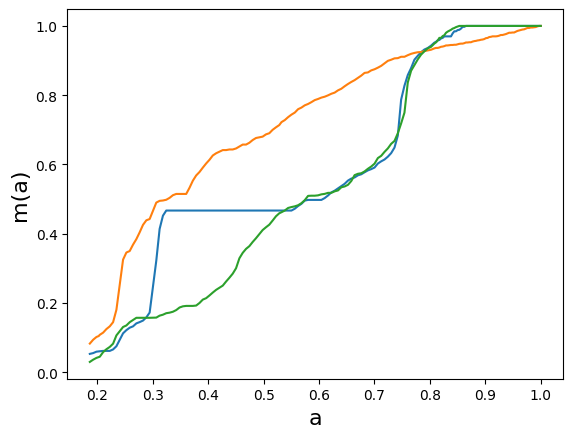

In [6]:
# plot the mass assembly history of a random halo
plt.plot(scales, ma[0])
plt.plot(scales, ma[10])
plt.plot(scales, ma[20])
plt.xlabel('a', fontsize=16)
plt.ylabel('m(a)', fontsize=16)
plt.show()

As you can see all our monotonically increasing and by the definition end up at $m(a) = 1$ when $a = 1$ or $z = 0$. 

The dataset also contains ROCKSTAR present-day properties of the haloes. This includes concentration, centre-of-mass offset, virial ratio, spin, and triaxiality. Let's access these properties:

In [7]:
cat = mah_data['cat'] # astropy table with present-day halo properties
cvir = cat['cvir']
xoff = cat['x0']
t_over_u = cat['t/|u|']
spin = cat['spin_bullock']
c_to_a = cat['c_to_a']

cvir.shape, spin.shape # 1 dimensional quantities, one per halo

((10000,), (10000,))

## Setup the model and train

For the purposes of this tutorial we will use the MAH information and halo properties as features and targets for prediction respectively. In this section, we will walk you through how to setup the MultiCAM model and train it.

First we import relevant classes from `mah.models` module:

In [8]:
from multicam.models import MultiCamSampling

The `LinearRegression` model implements the option of using the MultiCAM framework with a linear regression algorithm for connecting features and targets within the gaussianized space (see Fig 1 of the MultiCAM paper).

First we need to create an instance of the model. For now, let's use the model to predict concentration from MAH only.

In [9]:
n_features = ma.shape[1] # number of features is the number of scales
n_targets = 1 # number of targets is 1, the present-day halo property
model = MultiCamSampling(n_features, n_targets)

Lastly before training, let's split the data into training and testing: 

In [10]:
from multicam.models import _get_tt_indices

n_haloes = len(cat)
train_idx, test_idx = _get_tt_indices(n_haloes, test_ratio=0.25)

In [13]:
ma_train = ma[train_idx]
ma_test = ma[test_idx]
cvir_train = cvir[train_idx]
cvir_test = cvir[test_idx]

The last flag means that we are using the MultiCAM framework which includes a gaussianization step and matching quantiles. If this flag is turned off, then the model will simply be a linear regression model.

Now we can proceed with training, the only thing to be careful with is that all features and targets need to be reshaped to be 2D arrays if they are not already. To train we use the `.fit()` method of the model:

In [14]:
model.fit(ma_train, cvir_train.reshape(-1, 1)) # reshape to 2D array

and that's it! We are ready to predict with this model.

## Prediction and results

To predict, simply use the `.predict()` method of the model on the test features: 

In [15]:
cvir_pred = model.predict(ma_test)

We can compare them to the test concentration via a histogram: 

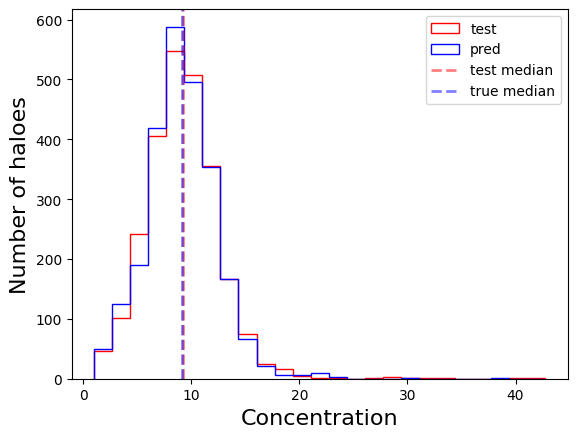

In [22]:
_, bins, _ = plt.hist(cvir_test, label='test', histtype='step', bins=25, color='r')
plt.hist(cvir_pred, label='pred', histtype='step', bins=bins, color='b')
plt.axvline(np.mean(cvir_test),  ls='--', label='test median', alpha=0.5, lw=2, color='r')
plt.axvline(np.mean(cvir_pred), ls='--', label='true median', alpha=0.5, lw=2, color='b')
plt.xlabel('Concentration', fontsize=16)
plt.ylabel('Number of haloes', fontsize=16)
plt.legend()
plt.show()

We can also examine their spearman correlation coefficient as in the paper.

In [15]:
from multicam.correlations import spearmanr

spearmanr(cvir_test, cvir_pred)

np.float64(0.7850524829108033)

## Multivariable prediction 

MultiCAM enables the prediction of multiple targets at once. Let's try to predict concentration, virial ratio, centre-of-mass offset, spin, and triaxility all at once. 

For this we create new model, using the same class as before. 

In [ ]:
n_features = ma.shape[1]
n_targets = 5 # <---- note the change since we are predicting multiple targets
mv_model = MultiCamSampling(n_features, n_targets)

Now to carefully stack the corresponding variables to use. 

In [24]:
x = ma 
y = np.vstack([cvir, xoff, t_over_u, spin, c_to_a]).T # just need to remember the order of the targets
x.shape, y.shape

((10000, 165), (10000, 5))

and doing the train/test split again... 

In [25]:
train_idx, test_idx = _get_tt_indices(n_haloes, test_ratio=0.25)
x_train = x[train_idx]
x_test = x[test_idx]
y_train = y[train_idx]
y_test = y[test_idx]

Fit and predict as before:

In [26]:
mv_model.fit(x_train, y_train)

In [27]:
y_pred = mv_model.predict(x_test)

Compute spearman correlation coefficients:

In [28]:
# compute spearman correlation for each target
target_names = ['cvir', 'xoff', 't_over_u', 'spin', 'c_to_a']
for i in range(n_targets):
    print(f'{target_names[i]}:', spearmanr(y_test[:, i], y_pred[:, i]))

cvir: 0.8049005143105833
xoff: 0.641124260773751
t_over_u: 0.7518288156889678
spin: 0.4930390321524966
c_to_a: 0.497423862201014


Of course, more complicated analysis and or plots can be done from `y_pred` and `y_test` as desired.